# Introduction

This workshop shows the protocol **INCER-ACV** and the complementary library [lca_algebraic](https://github.com/oie-mines-paristech/lca_algebraic) developed in the framework of the ADEME project INCER-ACV (2017-2020), using the **simplified case study** of a **photovoltaïc** facility as an example.

Full information about lca_algebraic fonctions is [available online](https://lca-algebraic.readthedocs.io/en/stable/)

We invite you to open this notebook and run all its cells in order. 

Certain sections require some cells to be completed (TODO), they are highlighted with the icone `🔧` : use previous cells as an example to fill in the missing code.

Other cells contain questions and ask you to examine the results. They are marked with an `💡`


# Initialization

Instractions for initialization of the library are grouped in an external file named "init.py"

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import bw2data as bd
import bw2io as bi
import lca_algebraic as agb

In [2]:
# To do : update the name of the bightway project
NAME_PROJECT='workshop-bw25'

# To do : update the name of the user database that will be stored in the brightway project
USER_DB='foreground'

In [3]:
#Open a brightway project associated with the project name chosen
bd.projects.set_current(NAME_PROJECT)

In [4]:
# Import Ecoinvent Database (should be done only once)
if len(bd.databases) > 0:
    print("Initial setup already done, skipping")
else:
    bi.import_ecoinvent_release(
        version="3.10.1",
        system_model="cutoff",
        use_mp=True)

Applying strategy: normalize_units
Applying strategy: drop_unspecified_subcategories
Applying strategy: ensure_categories_are_tuples
Applied 3 strategies in 0.01 seconds
Graph statistics for `ecoinvent-3.10.1-biosphere` importer:
4362 graph nodes:
	emission: 4000
	natural resource: 344
	inventory indicator: 13
	economic: 5
0 graph edges:
0 edges to the following databases:
0 unique unlinked edges (0 total):




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4362/4362 [00:00<00:00, 17156.27it/s]

18:14:47+0200 [info     ] Vacuuming database            


Created database: ecoinvent-3.10.1-biosphere
Extracting XML data from 23523 datasets
18:15:34+0200 [info     ] Extracted 23523 datasets in 45.64 seconds
Applying strategy: normalize_units
Applying strategy: update_ecoinvent_locations
Applying strategy: remove_zero_amount_coproducts
Applying strategy: remove_zero_amount_inputs_with_no_activity
Applying strategy: remove_unnamed_parameters
Applying strategy: es2_assign_only_product_with_amount_as_reference_product
Applying strategy: assign_single_product_as_activity
Applying strategy: create_composite_code
Applying strategy: drop_unspecified_subcategories
Applying strategy: fix_ecoinvent_flows_pre35
Applying strategy: drop_temporary_outdated_biosphere_flows
Applying strategy: link_biosphere_by_flow_uuid
Applying strategy: link_internal_technosphere_by_composite_code
Applying strategy: delete_exchanges_missing_activity
Applying strategy: delete_ghost_exchanges
Applying strategy: remove_uncertainty_from_negative_loss_exchanges
Applying stra

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23523/23523 [00:51<00:00, 456.22it/s]


18:16:34+0200 [info     ] Vacuuming database            
Created database: ecoinvent-3.10.1-cutoff


In [5]:
# We use a separate DB for defining our model, reset it beforehand
agb.resetDb(USER_DB)

# Reset the definition of all parameters 
agb.resetParams()

In [6]:
# Print the databases that have been set up with lca_algebraic function
agb.list_databases() 

#It also works with the following command
#bw.databases

,backend,nb_activities,type
name,,,
ecoinvent-3.10.1-biosphere,sqlite,4362,biosphere
ecoinvent-3.10.1-cutoff,sqlite,23523,background
foreground,sqlite,0,foreground


In [7]:
#Optional : if you need to delete a USER_DB
# del bd.databases[USER_DB]

In [8]:
#Optional : If you need to manipulate a database, give it a variable name
#ecoinvent_3_4 = bw2data.Database('ecoinvent 3.4')

# Parameter definition 

Firstly, we define the parameters needed for the system's modeling (photovoltaic -PV- facility).

**lca_algebraic** allows the definition of 3 types of parameters :
* Numerical values, via the method `newFloatParam(...)`
* Boolean value (0 or 1), via the method `newBoolParam(...)`
* Exclusive choice, corresponding internally to the definition of several boolean parameters, via the function `newEnumParam(...)`

For each parameter, we define:
* The name (short) and the label (long)
* The value by default
* The minimum and maximum values, and the probability distribution (uniform by default)
* The unit
* The "group" : a way of organizing the parameters
* A description

The variable parameters resulting from this definition will be later used in typical Python expressions, to define the amounts of the inventory. 

In [9]:
# The nominal power installed 
nom_power = agb.newFloatParam(
    "nom_power", # Short name
    default=1500, min=3, max=3000, # Default value and minimum and maximum values : uniform distribution by default
    label_fr='puissance installee', # Long label
    group="installation", # Group
    unit="kWp") # unit : kWp

## Parameter specificities : delayed evaluation

Contrarily to typical Python variables, the **parameters** defined here are *SymPy* expressions: they are not directly evaluated when included in the expressions. They define formulas literally, which can then be used in the inventory and will be manipulated/evaluated later by the library.

In [10]:
# typical python variable
a = 2

# The evaluation is direct
a + 2

4

In [12]:
# On the contrary, a parameter defined with lca_algebraic, used in a mathematical expression, 
# results in a new algebraic formula, which will be later manipulated by the library
4 * nom_power + 2

4*nom_power + 2

In [13]:
# The efficiency of a module, in kWc per m2
efficiency_module = agb.newFloatParam(
    "efficiency_module",
    distrib=agb.DistributionType.TRIANGLE, # Triangle distribution, asigning higher likelihood to values near the default value
    default=0.175, min=0.15, max=0.22,
    group="installation",
    label_fr="efficacite module",
    description="efficiency of the module per installed surface",
    unit="kWp/m²")

In [14]:
# Boolean parameter defining the type of installation
#  1 : rooftop installation 
#  0 : gound installation 
rooftop = agb.newBoolParam(
    "rooftop",
    1, # Default value : rooftop
    group="installation",
    label="roof system",
    label_fr="installation sur toit",
    description="defines the type of installation (rooftop / ground)")

In [15]:
# Selection parameter "enum" among several exclusive choices of electricity mix
# Internally, the parameter defines 5 boolean parameters:
elec_mix = agb.newEnumParam(
    'elec_mix', # Name of the parameter
    values={ # Statistical likelihood of each option, corresponding to current market reality.
        "jp": 2.4,
        "kr": 7.4,
        "cn": 71.4,
        "ml": 5.7,
        "in": 2.1
    },
    default="cn", # Default value
    label_fr='mix electrique',
    group='manufacturing', # Classification of parameters in "groups"
    description="electricity mix used in the production of a module")

## 🔧  Inverter lifetime

Define a parameter "inverter_lifetime" with a 15 year value with a triangle distribution between 10 and 30 in the group "production"

In [16]:
# Inverter lifetime 
# TODO
lifetime_inverter = agb.newFloatParam(
    "inverter_lifetime",
    label_fr="durée vie onduleur",
    distrib=agb.DistributionType.TRIANGLE,
    default=15, min=10, max=30,
    group="production",
    unit="year")

In [17]:
# Distance travelled for the installation, by lorry
d_lorry = agb.newFloatParam(
    "d_lorry",
    default=1020, min=40, max=2000,
    unit="km",
    group="transport",
    label_fr="distance par camion")

In [18]:
# Distance travelled for the installation, by train
d_train = agb.newFloatParam(
    "d_train",
    default=350, min=100, max=600,
    unit="km",
    group="transport",
    label_fr="distance par train")

In [19]:
# Distance travelled for the installation, by ship 
d_ship = agb.newFloatParam(
    "d_ship",
    default=4000, min=2000, max=6000,
    unit="km",
    group="transport",
    label_fr="distance par bateau")

In [20]:
# The annual producible is expressed per installed capacity per year
# This parameter defines what production we can expect annually for an installation of 1 kWp
# It translates the differences in resources (solar radiation) and of the installation (orientation, shading...)
# We have obtained a reliable estimate of this parameter thanks to
# the study on domestic installations database DBPV (www.bdpv.fr)
producible = agb.newFloatParam(
    "producible",
    distrib=agb.DistributionType.NORMAL, # Normal distribution
    default=1050, min=500, max=1500, std=150, # Centered around the default value: 1050, standard deviation : 150
    group="production",
    label_fr="productible annuel",
    description="real annual producible per installed capacity, including transformation losses",
    unit="kWh/kWp/year")

In [21]:
# Panel degradation, in fraction per year 
degradation_rate = agb.newFloatParam(
    "degradation_rate",
    distrib=agb.DistributionType.TRIANGLE, 
    default=0.005, min=0.005, max=0.008,
    group="production",
    label="degratation rate",
    label_fr="taux de dégradation",
    unit="fraction/year")

In [22]:
# Coverage ratio for ground installation (=spread of the support)
ground_coverage_ratio = agb.newFloatParam(
    "ground_coverage_ratio",
    default=0.45, min=0.1, max=0.45,
    distrib=agb.DistributionType.TRIANGLE,
    group="installation",
    label_fr="couverture au sol",
    description="ground coverage ratio (for installations on the ground)",
    unit="fraction")

In [23]:
# Estimated lifetime of the complete system
lifetime = agb.newFloatParam(
    "lifetime",
    default=30, min=20, max=40,
    distrib=agb.DistributionType.TRIANGLE,
    group="production",
    label="pv lifetime",
    # label_fr="durée de vie module",
    label_fr="durée de vie",
    description="estimated lifetime of the system",
    unit="years")

## List of parameters

In [24]:
# Compact display of the list of defined parameters
agb.list_parameters()

group,name,label,default,min,max,std,distrib,unit,db
installation,efficiency_module,efficiency module,0.175,0.15,0.22,,triangle,kWp/m²,[project]
installation,ground_coverage_ratio,ground coverage ratio,0.45,0.1,0.45,,triangle,fraction,[project]
installation,nom_power,nom power,1500,3,3000,,linear,kWp,[project]
installation,rooftop,roof system,1,,,,,,[project]
manufacturing,elec_mix,elec mix,cn,,,,,,[project]
production,degradation_rate,degratation rate,0.005,0.005,0.008,,triangle,fraction/year,[project]
production,inverter_lifetime,inverter lifetime,15,10,30,,triangle,year,[project]
production,lifetime,pv lifetime,30,20,40,,triangle,years,[project]
production,producible,producible,1050,500,1500,150,normal,kWh/kWp/year,[project]
transport,d_lorry,d lorry,1020,40,2000,,linear,km,[project]


# Definition of the inventory

We now build the inventory of the system, by selecting (and modifying) the  activities from the *background* system, coming from **Ecoinvent** and using the above-defined parameters to express their amounts.

We build this inventory in a database specific of the user `USER_DB`, separated from *ecoinvent*, to avoid the original ecoinvent database to be modified by mistake).

**lca_algebraic** provides several methods that can be used for this step :
* [findTechAct(name, loc*)](https://oie-mines-paristech.github.io/lca_algebraic/doc/helpers.html#lca_algebraic.helpers.findTechAct) et [findBioAct(name, loc*)](https://oie-mines-paristech.github.io/lca_algebraic/doc/helpers.html#lca_algebraic.helpers.findBioAct) allow the background inventories (activities) to be chosen, both for the biosphere and the technosphere. When working with several background databases at the same time, we can replace findTechAct(name, loc*) by findActivity(name, loc, db_name) which  makes it possible to select a given database source.
* [copyActivity()](https://oie-mines-paristech.github.io/lca_algebraic/doc/helpers.html#lca_algebraic.helpers.copyActivity) allows an existing inventory of the user database to be copied, so as to modify it.
* [newActivity()](https://oie-mines-paristech.github.io/lca_algebraic/doc/helpers.html#lca_algebraic.helpers.newActivity) creates a new inventory in the database.

## findBioAct / findTechAct

**finTechAct(name, loc*)** (for technosphere, analogous to findBioAct for biosphere) allows the selection of existing inventories by name and location.  

The parameter **name** accepts either the complete name of the activity, or a part of the name (followed by symbol `*`)

By default, **finTechAct** expects a single correspondence, and it will show an error message if this is not the case, unless an additional parameter is provided. If the parameter `single` is **False**, **findTechAct** will show the first 100 correspondences. 

In [25]:
# List of corresponding activities
agb.findBioAct("Water*", single=False)

['Water' (cubic meter, None, ('water', 'surface water')),
 'Water' (cubic meter, None, ('water',)),
 'Water' (cubic meter, None, ('water', 'ocean')),
 'Water' (cubic meter, None, ('water', 'ground-')),
 'Water' (cubic meter, None, ('water', 'fossil well')),
 'Water' (cubic meter, None, ('water', 'ground-, long-term')),
 'Water, lake' (cubic meter, None, ('natural resource', 'in water')),
 'Water, river' (cubic meter, None, ('natural resource', 'in water')),
 'Water, salt, sole' (cubic meter, None, ('natural resource', 'in water')),
 'Water, salt, ocean' (cubic meter, None, ('natural resource', 'in water')),
 'Water, unspecified natural origin' (cubic meter, None, ('natural resource', 'in water')),
 'Water, well, in ground' (cubic meter, None, ('natural resource', 'in water')),
 'Water, cooling, unspecified natural origin' (cubic meter, None, ('natural resource', 'in water')),
 'Water' (cubic meter, None, ('air',)),
 'Water, turbine use, unspecified natural origin' (cubic meter, None, (

In [26]:
# Single result
agb.findBioAct('Water, in air')

'Water, in air' (cubic meter, None, ('natural resource', 'in air'))

## 🔧  Exercise findTechAct

Find a PV panel activity named "photovoltaic panel", in multi-Si, for the location "RER"

Keep this activity in a variable parameter named **panel_init** : we will use it later


In [27]:
# TODO : refine the search until getting a single result. 
# You can also use the second parameter loc=,  to indicate the location
panel_init = agb.findTechAct("photovoltaic panel production, multi-Si wafer", loc="RER")
panel_init

'photovoltaic panel production, multi-Si wafer' (square meter, RER, None)

## Mounting system

We select a standard mounting system and we adapt it to the case of a ground-mounted installation.

In [28]:
# Selection of ground-mounted system
mounting = agb.findTechAct('photovoltaic mounting system production, for 570kWp open ground module')

# Copy in the user database (USER_DB) to modify it
mounting_modified = agb.copyActivity(
    USER_DB, # user database
    mounting, # initial activity
    "mounting system adjusted") # New name

# Print act helps us explore the exchanges in an activity: name, input, quantity
agb.printAct(mounting)

photovoltaic mounting system production, for 570kWp open ground module (1.000000 square meter)  \
                                                                                                                                        input   
Occupation, industrial area                                           Occupation, industrial area                                               
Transformation, from pasture, man made                     Transformation, from pasture, man made                                               
Transformation, to industrial area                             Transformation, to industrial area                                               
aluminium, wrought alloy                                      market for aluminium, wrought alloy                                               
concrete, normal strength                              market group for concrete, normal strength                                               
corrugated board box                                          market for corrugated board box[US]                                               
corrugated board box#1                                     market for corrugated board box[CA-QC]                                               
corrugated board box#2                                       market for corrugated board box[RER]                                               
corrugated board box#3                                       market for corrugated board box[RoW]                                               
polyethylene, high density, granulate            market for polyethylene, high density, granulate                                               
polystyrene, high impact                                      market for polystyrene, high impact                                               
reinforcing steel                                                    market for reinforcing steel                                               
scrap aluminium                                                   market for scrap aluminium[RoW]                                               
scrap aluminium#1                               market for scrap aluminium[Europe without Swit...                                               
scrap aluminium#2                                                  market for scrap aluminium[CH]                                               
scrap steel                                                           market for scrap steel[RoW]                                               
scrap steel#1                                   market for scrap steel[Europe without Switzerl...                                               
scrap steel#2                                                          market for scrap steel[CH]                                               
section bar extrusion, aluminium                      market for section bar extrusion, aluminium                                               
section bar rolling, steel                                  market for section bar rolling, steel                                               
steel, chromium steel 18/8, hot rolled          market for steel, chromium steel 18/8, hot rolled                                               
waste paperboard, unsorted                      waste paperboard, unsorted, Recycled Content c...                                               
waste polyethylene/polypropylene product        market for waste polyethylene/polypropylene pr...                                               
waste polyethylene/polypropylene product#1      market for waste polyethylene/polypropylene pr...                                               
waste polyethylene/polypropylene product#2      market for waste polyethylene/polypropylene pr...                                               
waste polystyrene isolation, flame-retardant    market for waste polystyrene isolation, flame-...                                   

In [29]:
# Opposite parameter to "sur_toit"
ground_mounted = (1-rooftop)

# Land use: activity only used in case of ground-mounted installation
land_use_PV = 1 / ground_coverage_ratio * ground_mounted

# Modification of land use
# We use here a syntaxis from a python dictionary {key:value, key2, value2, ...}
# updateExchanges accepts a dictionary in which the keys sont names of exchanges (=flows) 
# (+ in some cases #LOC) and the values can be :
#  - an activity, to replace the initial target activity
#  - a value (either static or arithmetic/with parameters) to change the amount
mounting_modified.updateExchanges({
   'Transformation, to industrial area' : land_use_PV,
   'Transformation, from pasture, man made' : land_use_PV,
   'Occupation, industrial area' : land_use_PV * lifetime })

# Removal of concrete activities for the rooftop installation
mounting_modified.updateExchanges({
   'concrete, normal strength' : 0.000541 * ground_mounted,
})

# TODO Removal of zinc activities for the rooftop installation
mounting_modified.updateExchanges({
   'zinc coat, coils' : 0.11 * ground_mounted,
   'zinc coat, pieces' : 0.156 * ground_mounted})

# To show/compare activities before and after modification
# Differences are highlighted in yellow
# Please note that the amounts are not constant values anymore, but have become, instead, arithmetic formulas 
# dependent on input parameters
agb.printAct(mounting, mounting_modified)

## Electricity mix

We define a virtual electricity mix, by choosing the suitable mix depending on the value of the parameter **elec_mix**
From an arithmetical point of view, this mix is a linear combination of national mixes, weighted by boolean parameters (0 or 1) :
> elec = elec_cn * "param elec_mix=cn" + elec_in * "param elec_mix=in" ... etc

In this section, we are using the function [newSwitchAct](https://oie-mines-paristech.github.io/lca_algebraic/doc/helpers.html#lca_algebraic.helpers.newSwitchAct) : this function is shorcut for **newActivity** making it easier to simply define an inventory only pointing at other activities with respect to discrete parameters.

In [31]:
# Generic name of electricity mix
ELEC_NAME = 'market for electricity, medium voltage'
ELEC_GROUP_NAME = 'market group for electricity, medium voltage'

# Selection of background activities in ecoinvent 
# Note the use of second parameter "loc" that allows us to choose the region of the target activity
elec_cn = agb.findTechAct(ELEC_NAME, "CN-CSG")
elec_jp = agb.findTechAct(ELEC_NAME, "JP")
elec_kr = agb.findTechAct(ELEC_NAME, "KR")
elec_ml = agb.findTechAct(ELEC_NAME, "MY")
elec_in = agb.findTechAct(ELEC_GROUP_NAME, "IN")

In [32]:
# Creation of a virtual "switch" activity controled by the parameter elec_mix
# This activity is a sum of electricity mix * boolean parameter
elec = agb.newSwitchAct(USER_DB, "elec", elec_mix, {
    "cn" : elec_cn,
    "jp" : elec_jp,
    "in" : elec_in,
    "ml" : elec_ml,
    "kr" : elec_kr})

# Display of created activity : 
# *printAct* shows an inventory in the format of a table
# Please note that the column "amount" : these are not fixed amounts, but a reference 
# to boolean parameters mutually exclusive : a single mix active at each run of the model
agb.printAct(elec)

elec (1.000000 kilowatt hour)  \
                                                                                         input   
market for electricity, medium voltage          market for electricity, medium voltage[CN-CSG]   
market for electricity, medium voltage#1            market for electricity, medium voltage[JP]   
market for electricity, medium voltage#2            market for electricity, medium voltage[MY]   
market for electricity, medium voltage#3            market for electricity, medium voltage[KR]   
market group for electricity, medium voltage  market group for electricity, medium voltage[IN]   

                                                                          
                                                   amount           unit  
market for electricity, medium voltage        elec_mix_cn  kilowatt hour  
market for electricity, medium voltage#1      elec_mix_jp  kilowatt hour  
market for electricity, medium voltage#2      elec_mix_ml  kilowatt hour  
market for electricity, medium voltage#3      elec_mix_kr  kilowatt hour  
market group for electricity, medium voltage  elec_mix_in  kilowatt hour

##  PV panel

In [33]:
# panel_init has been selected above

# Copy in the user database for mofidication
panel_modified = agb.copyActivity(USER_DB, panel_init, 'photovoltaic panel production, multi-Si wafer - adjusted')
agb.printAct(panel_init)

photovoltaic panel production, multi-Si wafer[RER] (1.000000 square meter)  \
                                                                                                                        input   
1-propanol                                                                      market for 1-propanol                           
Water                                                                                           Water                           
acetone, liquid                                                       market for acetone, liquid[RER]                           
aluminium alloy, AlMg3                                              market for aluminium alloy, AlMg3                           
brazing solder, cadmium free                                  market for brazing solder, cadmium free                           
copper, cathode                                                            market for copper, cathode                           
corrugated board box                                             market for corrugated board box[RER]                           
electricity, medium voltage                         market group for electricity, medium voltage[RER]                           
ethylvinylacetate, foil                                            market for ethylvinylacetate, foil                           
glass fibre reinforced plastic, polyamide, inje...  market for glass fibre reinforced plastic, pol...                           
heat, district or industrial, natural gas           market group for heat, district or industrial,...                           
lubricating oil                                                       market for lubricating oil[RER]                           
methanol                                                                     market for methanol[RER]                           
municipal solid waste                                     market group for municipal solid waste[RER]                           
nickel, class 1                                                            market for nickel, class 1                           
photovoltaic cell, multi-Si wafer                        market for photovoltaic cell, multi-Si wafer                           
photovoltaic panel factory                                      market for photovoltaic panel factory                           
polyethylene terephthalate, granulate, amorphous    market for polyethylene terephthalate, granula...                           
polyvinylfluoride, film                                            market for polyvinylfluoride, film                           
silicone product                                                     market for silicone product[RER]                           
solar glass, low-iron                                                market for solar glass, low-iron                           
tap water                                                             market group for tap water[RER]                           
tempering, flat glass                                                      tempering, flat glass[RER]                           
vinyl acetate                                                                market for vinyl acetate                           
waste mineral oil                                                    market for waste mineral oil[CH]                           
waste mineral oil#1                                 market for waste mineral oil[Europe without Sw...                           
waste plastic, mixture                                   market group for waste plastic, mixture[RER]                           
waste polyvinylfluoride                                        market for waste polyvinylfluoride[CH]                           
wastewater, average                                                market for wastewater, average[CH]                           
wastewater, average#1                               

In [34]:
# Change of electricity mix
# Find the name of the electricity mix in the previous inventory, and change it by the virtual mix
# defined above.
# Please remind that the values of updateExchanges can be either an amount or an activity
# TODO 
panel_modified.updateExchanges({
    'electricity, medium voltage': elec})

# Comparison
agb.printAct(panel_init, panel_modified)

## Complete installation

In this stage, we put together the elements that have been defined above in a complete inventory of the system.

In [35]:
# Selection of background activities
diesel = agb.findTechAct('market for diesel, burned in building machine')

# Electrical installation typical of 3 kWp
electrical_installation_3kW = agb.findTechAct('photovoltaics, electric installation for 3kWp module, at building', 'RoW')

# Inverter for a 500 kWp installation
inverter_500kW = agb.findTechAct('inverter production, 500kW', 'RER')

# Calculation of the effective surface of a module
surface  = nom_power / efficiency_module 

# Final creation of the complete inventory
install = agb.newActivity(USER_DB, "full pv installation", "unit")

# Exchanges are defined as a dictionary of 
# <activity> : <amount>
install.addExchanges({ 
    
    # Supporting structure 
    mounting_modified :  surface,

    # Diesel consumed by the land preparation
    # 7673 MJ for a 570 kWp
    diesel : ground_mounted * nom_power/570 * 7673,

    # Electrical installation : rule of three, with respect to a 3 kWp installation
    electrical_installation_3kW : nom_power/3,

    # Number of inverters
    inverter_500kW : nom_power/500,
    
    # PV Panel itself, in surface
    panel_modified : surface})

## 🔧 Add transport to the inventory

Complete this cell to add the transport to the inventory.
Be careful with the units! The amounts of transport of goods are expressed in tonnes.km

The following amounts are to be used :
* **Car** : 150km fix, transport of engineers for the feasibility study
* **Van** : Transport of the inverter, over 100 km fix, as many times as replacements are needed : use the parameters **lifetime** et **lifetime_inverter**  
* **Lorry, Ship & Train** : transport de la masse totale. Utilisez les paramètres : **d_lorry**, **d_ship** et **d_train**

In [36]:
# -- Selection of transport activities

# In Km
transport_car = agb.findTechAct('transport, passenger car, large size, petrol, EURO 5', 'RER')

# In Tonne.Km
transport_van = agb.findTechAct('transport, freight, light commercial vehicle', 'Europe without Switzerland')
transport_lorry = agb.findTechAct('lorry, all sizes, EURO6*', 'RER')
transport_train = agb.findTechAct('transport, freight train, electricity', 'RoW')
transport_ship = agb.findTechAct('transport, freight, sea, container ship')

# An inverter of 500 kW weighs 1570kg 
# Rule of three for the weight of the inverter, in tonnes
# Weight of the inverter, tons
weight_inverter = 1.570 * nom_power / 500

# PV panels weigh 20 kg / m2
# Total weight, in tons
total_weight = 1e-3 * surface * 20 + weight_inverter * lifetime / lifetime_inverter

# TODO   
install.addExchanges({    
    # Transport des ingénieur pour l'étude de faisabilité
    transport_car : 150,

    # Maintenance : changement des onduleurs
    transport_van : weight_inverter * 100 * lifetime / lifetime_inverter,

    # Transport du système complet sur site
    transport_lorry : total_weight * d_lorry,
    transport_ship : total_weight * d_ship,
})

# Display of complete inventory
agb.printAct(install)

full pv installation (1.000000 unit)  \
                                                                                                input   
inverter production, 500kW                                            inverter production, 500kW[RER]   
market for diesel, burned in building machine           market for diesel, burned in building machine   
mounting system adjusted                                                 mounting system adjusted{FG}   
photovoltaic panel production, multi-Si wafer -...  photovoltaic panel production, multi-Si wafer ...   
photovoltaics, electric installation for 3kWp m...  photovoltaics, electric installation for 3kWp ...   
transport, freight, light commercial vehicle        transport, freight, light commercial vehicle[E...   
transport, freight, lorry, all sizes, EURO6 to ...  transport, freight, lorry, all sizes, EURO6 to...   
transport, freight, sea, container ship                       transport, freight, sea, container ship   
transport, passenger car, large size, petrol, E...  transport, passenger car, large size, petrol, ...   

                                                                                                       \
                                                                                               amount   
inverter production, 500kW                                                              nom_power/500   
market for diesel, burned in building machine                        7673*nom_power*(1 - rooftop)/570   
mounting system adjusted                                                  nom_power/efficiency_module   
photovoltaic panel production, multi-Si wafer -...                        nom_power/efficiency_module   
photovoltaics, electric installation for 3kWp m...                                        nom_power/3   
transport, freight, light commercial vehicle               0.314*lifetime*nom_power/inverter_lifetime   
transport, freight, lorry, all sizes, EURO6 to ...  d_lorry*(0.00314*lifetime*nom_power/inverter_l...   
transport, freight, sea, container ship             d_ship*(0.00314*lifetime*nom_power/inverter_li...   
transport, passenger car, large size, petrol, E...                                                150   

                                                                   
                                                             unit  
inverter production, 500kW                                   unit  
market for diesel, burned in building machine           megajoule  
mounting system adjusted                             square meter  
photovoltaic panel production, multi-Si wafer -...   square meter  
photovoltaics, electric installation for 3kWp m...           unit  
transport, freight, light commercial vehicle        ton kilometer  
transport, freight, lorry, all sizes, EURO6 to ...  ton kilometer  
transport, freight, sea, container ship             ton kilometer  
transport, passenger car, large size, petrol, E...      kilometer

##  🔧  Expression of the model per functional unit

The impacts are divided by the apropriate amount to express per chosen functional unit. 

In the case of PV systems, we have the following options :
* The nominal **power** installed in **kWp**
* The **total energy** produced over the whole lifetime of the system, in **kWh**

In [37]:

# -- Model per functional unit

# Calculation of total energy produced over the lifetime
# Each year, the efficiency decreases based on the degradation rate.
# Sum of the terms of the geometric series :
energy = (producible * nom_power) * (1 - (1-degradation_rate)**lifetime) / degradation_rate



# Calculation of impacts



## Selection of impact assessment methods

In this example, we choose 3 impact categories among **ILCD** characterization methods imported with *Ecoinvent* database:
* **Climate change**, in kg CO2 equivalent
* **Mineral and metal resource depletion** in kg antimony equivalent (kg Sb eq),
* **Land use**, in kg organic matter loss

In [38]:
# Common prefix
EF = 'EF v3.1'

# Search for methods
[m for m in bd.methods if m[1] == EF and "climate" in m[2]]

[('ecoinvent-3.10.1',
  'EF v3.1',
  'climate change',
  'global warming potential (GWP100)'),
 ('ecoinvent-3.10.1',
  'EF v3.1',
  'climate change: biogenic',
  'global warming potential (GWP100)'),
 ('ecoinvent-3.10.1',
  'EF v3.1',
  'climate change: fossil',
  'global warming potential (GWP100)'),
 ('ecoinvent-3.10.1',
  'EF v3.1',
  'climate change: land use and land use change',
  'global warming potential (GWP100)')]

In [39]:
# The impacts are tuples of identifiers of ecoinvent database:
EI_310 = 'ecoinvent-3.10.1'

climate = (EI_310, EF, 'climate change', 'global warming potential (GWP100)')
resources = (EI_310, EF, 'material resources: metals/minerals', 'abiotic depletion potential (ADP): elements (ultimate reserves)')
land = (EI_310, EF, 'land use', 'soil quality index')

# We build a 3-impact list
impacts = [climate, resources, land]
impacts

[('ecoinvent-3.10.1',
  'EF v3.1',
  'climate change',
  'global warming potential (GWP100)'),
 ('ecoinvent-3.10.1',
  'EF v3.1',
  'material resources: metals/minerals',
  'abiotic depletion potential (ADP): elements (ultimate reserves)'),
 ('ecoinvent-3.10.1', 'EF v3.1', 'land use', 'soil quality index')]

## Individual calculation

The function `compute_impacts()` allows the calculation of several impacts simultaneously, for the values of the introduced values for the parameters : 

In [41]:
# This fonction allows the user to calculate several impacts at once, and to indicate the values for several parameters
agb.compute_impacts(
    install, # the full inventory
    impacts, # the list of impact methods

    # functional_unit=nom_power, Per Kwp
    functional_unit= energy, # Per Kwh

    # Parameters
    nom_power = 30)

[INFO] Db changed recently, clearing cache expr
[INFO] Required param 'degradation_rate' was missing, replacing by default value : 0.005
[INFO] Required param 'degradation_rate' was missing, replacing by default value : 0.005
[INFO] Required param 'rooftop' was missing, replacing by default value : 1
[INFO] Required param 'degradation_rate' was missing, replacing by default value : 0.005
[INFO] Required param 'rooftop' was missing, replacing by default value : 1
[INFO] Required param 'inverter_lifetime' was missing, replacing by default value : 15
[INFO] Required param 'rooftop' was missing, replacing by default value : 1
[INFO] Required param 'inverter_lifetime' was missing, replacing by default value : 15
[INFO] Required param 'd_ship' was missing, replacing by default value : 4000
[INFO] Required param 'inverter_lifetime' was missing, replacing by default value : 15
[INFO] Required param 'd_ship' was missing, replacing by default value : 4000
[INFO] Required param 'efficiency_module

,EF v3.1 - climate change[kg CO2-Eq],EF v3.1 - material resources: metals/minerals[kg Sb-Eq],EF v3.1 - land use[dimensionless]
full pv installation,0.0621064,3.21491e-06,0.243789


## 🔧 Compare the impacts of ground-mounted and rooftop installations

In [40]:
# TODO : Impacts of a rooftop installation
agb.compute_impacts(
    install, # the model
    impacts, # the list of impacts previously defined

    functional_unit = energy, # Per Kwh

    # Parameters
    rooftop=1)

[INFO] Required param 'd_ship' was missing, replacing by default value : 4000
[INFO] Required param 'd_ship' was missing, replacing by default value : 4000
[INFO] Required param 'd_lorry' was missing, replacing by default value : 1020
[INFO] Required param 'd_ship' was missing, replacing by default value : 4000
[INFO] Required param 'd_lorry' was missing, replacing by default value : 1020
[INFO] Required param 'elec_mix' was missing, replacing by default value : cn
[INFO] Required param 'd_lorry' was missing, replacing by default value : 1020
[INFO] Required param 'elec_mix' was missing, replacing by default value : cn
[INFO] Required param 'degradation_rate' was missing, replacing by default value : 0.005
[INFO] Required param 'elec_mix' was missing, replacing by default value : cn
[INFO] Required param 'degradation_rate' was missing, replacing by default value : 0.005
[INFO] Required param 'efficiency_module' was missing, replacing by default value : 0.175
[INFO] Required param 'degr

,EF v3.1 - climate change[kg CO2-Eq],EF v3.1 - material resources: metals/minerals[kg Sb-Eq],EF v3.1 - land use[dimensionless]
full pv installation,0.0620314,3.21413e-06,0.243423


In [42]:
# TODO : Impacts of a ground-mounted installation
agb.compute_impacts(
    install, # The model
    impacts, # the list of impacts previously defined

    functional_unit = energy, # per kWh


    # Parameter
    rooftop=0)

[INFO] Required param 'degradation_rate' was missing, replacing by default value : 0.005
[INFO] Required param 'inverter_lifetime' was missing, replacing by default value : 15
[INFO] Required param 'd_ship' was missing, replacing by default value : 4000
[INFO] Required param 'degradation_rate' was missing, replacing by default value : 0.005
[INFO] Required param 'efficiency_module' was missing, replacing by default value : 0.175
[INFO] Required param 'degradation_rate' was missing, replacing by default value : 0.005
[INFO] Required param 'inverter_lifetime' was missing, replacing by default value : 15
[INFO] Required param 'elec_mix' was missing, replacing by default value : cn
[INFO] Required param 'inverter_lifetime' was missing, replacing by default value : 15
[INFO] Required param 'd_ship' was missing, replacing by default value : 4000
[INFO] Required param 'producible' was missing, replacing by default value : 1050
[INFO] Required param 'd_ship' was missing, replacing by default v

,EF v3.1 - climate change[kg CO2-Eq],EF v3.1 - material resources: metals/minerals[kg Sb-Eq],EF v3.1 - land use[dimensionless]
full pv installation,0.0623429,3.28523e-06,4.37488


##  	💡  OAT (one at a time) variation of the parameters

By varying each parameter individually in its domain of definition (min max), we can have a first glance of the variability of the impacts and the relative importance of each parameter

In [43]:
# Interactive dashboard showing, for each parameter :
# * Graphs of the evolution per impact category
# * Raw data
# * A graph with the relative variation with each impact in percentage : (max-min) / mean
agb.oat_dashboard(install, impacts, functional_unit = energy)

# TODO : Explore the variations of different impacts
# For which impact category has the electricity mix the highest influence?
# For which impact category or categories for which the influence is, in principle, negligible?

interactive(children=(Dropdown(description='param', options=('degradation_rate', 'rooftop', 'inverter_lifetime…

A Jupyter widget could not be displayed because the widget state could not be found. This could happen if the kernel storing the widget is no longer available, or if the widget state was not saved in the notebook. You may be able to create the widget by running the appropriate cells.

,EF v3.1 - climate change,EF v3.1 - material resources: metals/minerals,EF v3.1 - land use
efficiency module,36.8745,20.8798,32.0894
ground coverage ratio,0,0,0
nom power,1.23238,0.248163,1.52962
roof system,0.500859,2.18795,178.917
elec mix,1.00525,0.00601886,0.664208
degratation rate,4.23103,4.23103,4.23103
inverter lifetime,0.138484,0.0148583,0.254879
pv lifetime,69.3254,69.4172,69.2391
producible,132.922,132.922,132.922
d lorry,1.97585,0.124439,5.43776


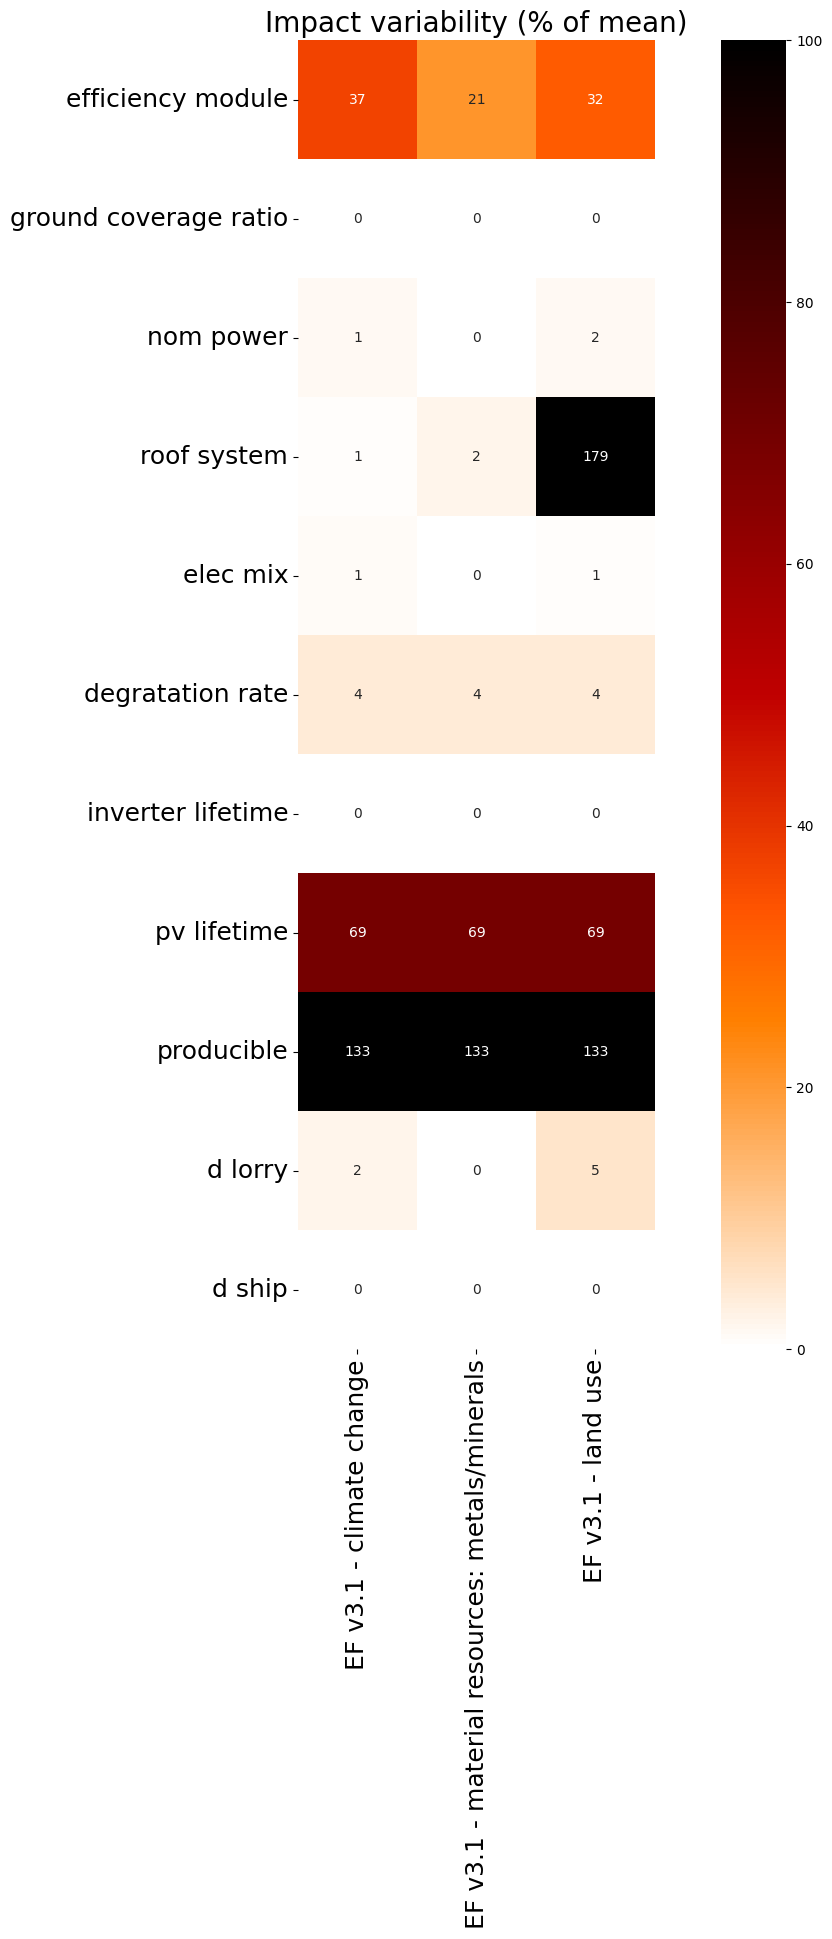

In [44]:
# Global view of the relative variations (min/max) for each parameter & impact
# We observe 3 types of parameters :
# * Dominant parameters for all impacts
# * Minor parameters for all impacts
# * Dominant parameters for certain impacts
agb.oat_matrix(install, impacts, functional_unit = energy)

# TODO : observe the impact of the parameter "ground coverage" 
# How do you explain that it is not identified as a remarkable contributor to the category "land use"?

##  💡  Statistic analysis 

The library *lca_algebraic*, allows the user to launch Monte Carlo random scenarios: That is, it provides a fast computation of a large number of impact values (> 100 000), for the values of different parameters.

The input parameters vary randomly based on statistical distributions defined above. The impacts are calculated for each random dataset.

The analysis of the results help evaluate finely the statistical variability of each environmental impact, and the importance of each parameter in this variability 


Generating samples ...
Transforming samples ...


,EF v3.1 - climate change [kg CO2-Eq / ],EF v3.1 - material resources: metals/minerals [kg Sb-Eq / ],EF v3.1 - land use [dimensionless / ]
median,0.0618099,3.27134e-06,1.56775
std,0.0137171,6.95767e-07,3.52562
p,"[0.04491533804883463, 0.08869006851939068]","[2.41912668592383e-06, 4.637191919126609e-06]","[0.18941799360703102, 9.54023370496131]"
mean,0.0637062,3.36948e-06,3.32308
var,0.215318,0.206491,1.06095


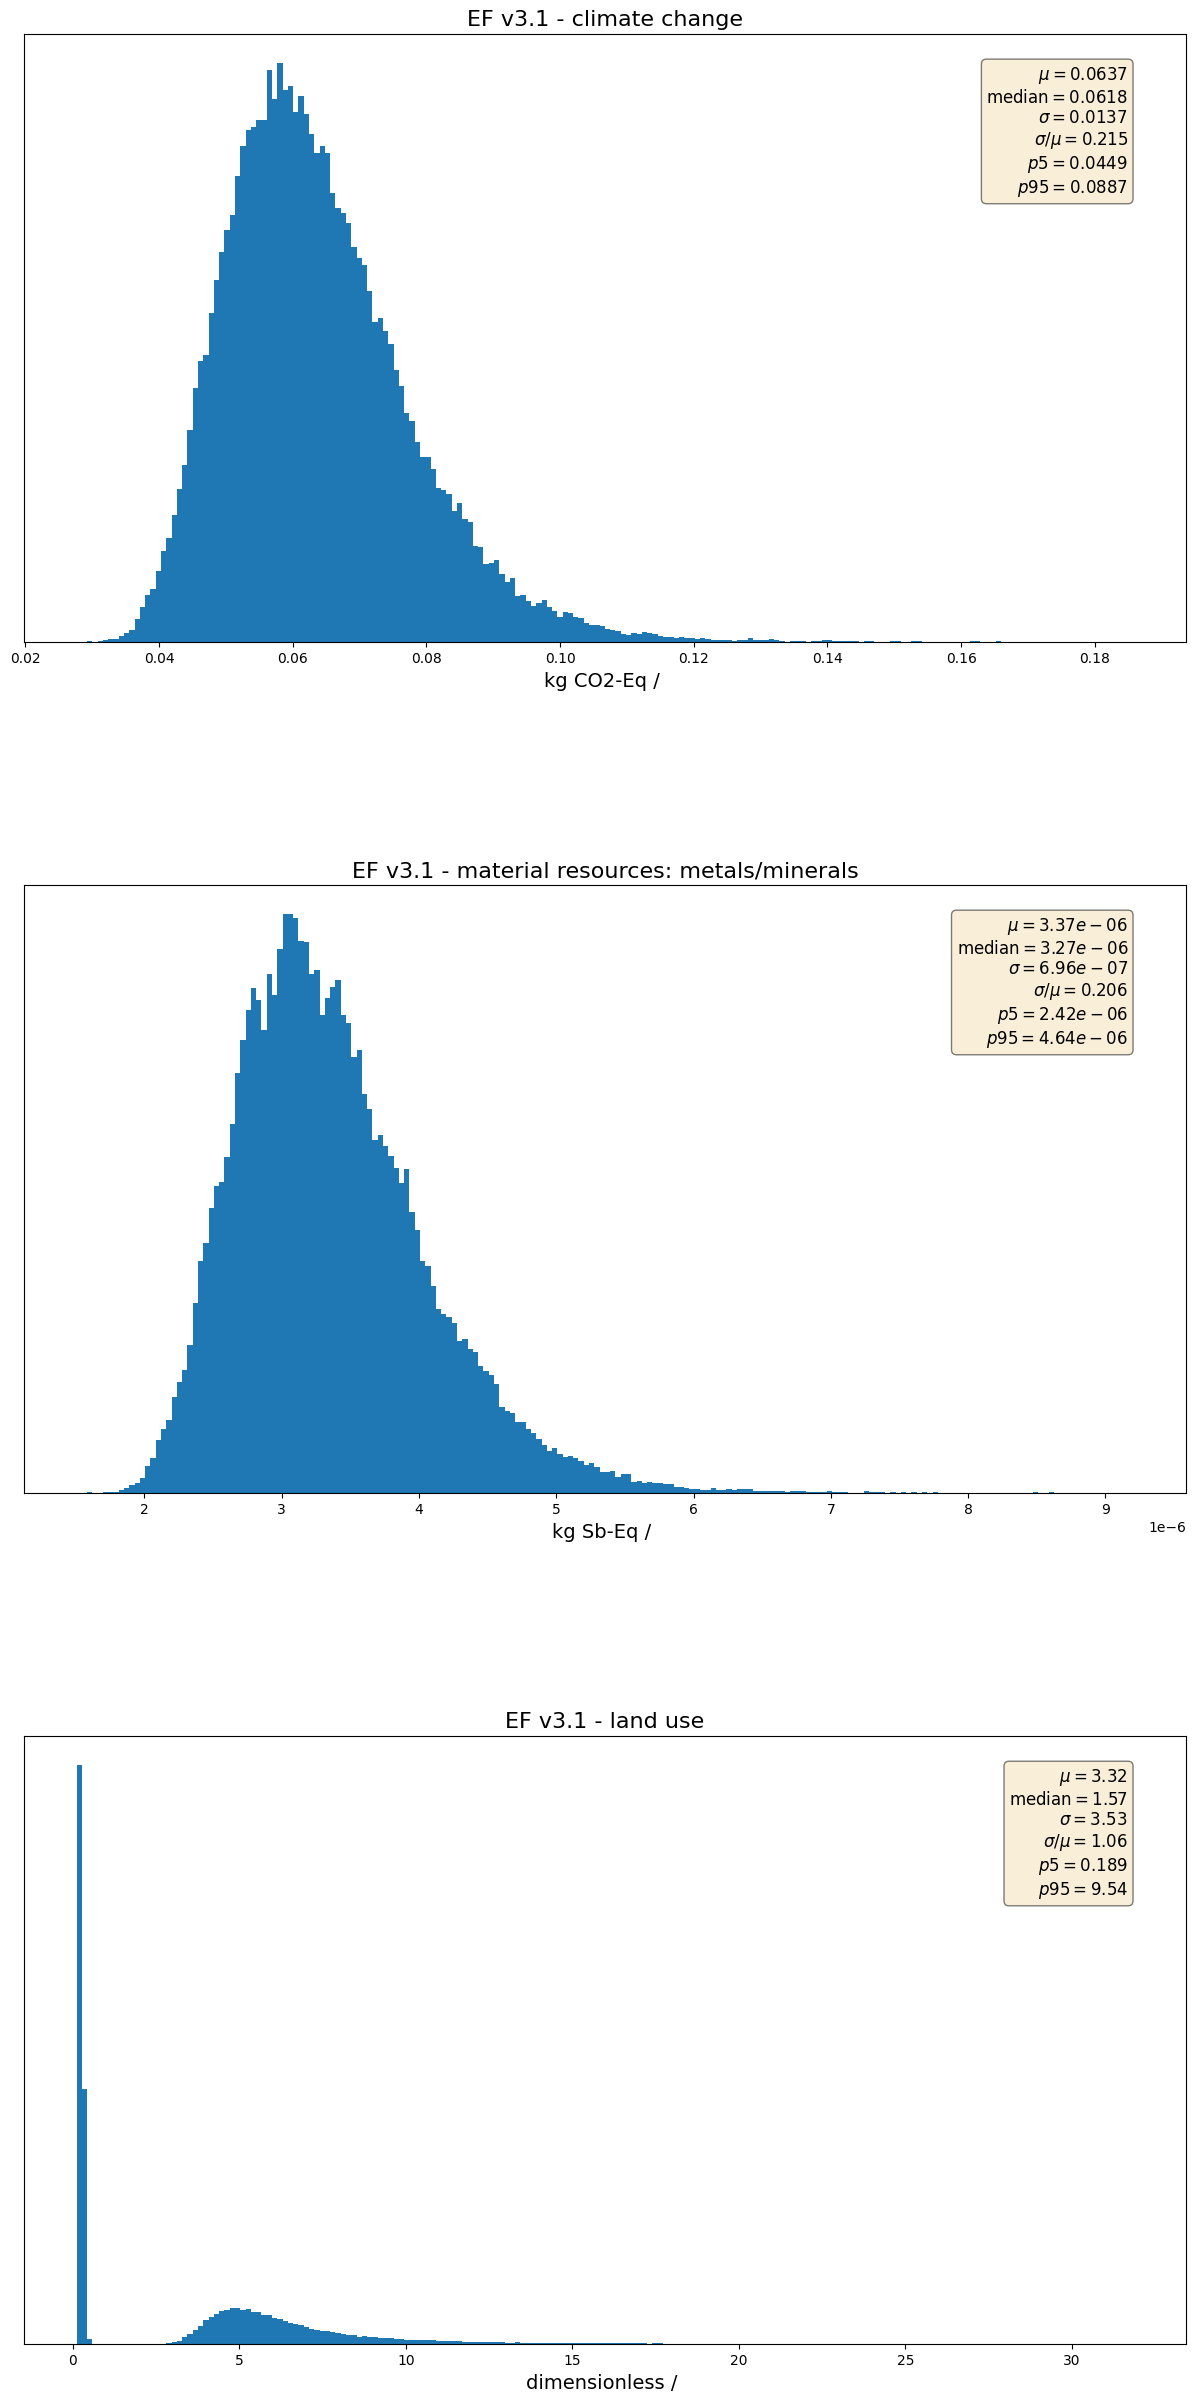

In [45]:
# The method "graphs" provides billions of Monte Carlo sampling points, 
# then track the output distribution of the impacts, using different statistical indicators :
# * mean
# * median
# * standard deviation
# * variability index (standard deviation / mean)
# * percentiles (5% et 95%) 
agb.distrib(install, impacts, functional_unit = energy)

# TODO : What is the standard deviation of climate impacts ? (in g.CO2 eq) 
# Compare to the extent of the OAT, for the variations of the single parameter "producible"

## 💡 Global sensitivity analysis & Sobol indices

Generating samples ...
Transforming samples ...
Processing Sobol indices ...
Processing sobol for ('ecoinvent-3.10.1', 'EF v3.1', 'climate change', 'global warming potential (GWP100)')


/home/rjolivet/atelier-acv/.venv/lib/python3.10/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


Processing sobol for ('ecoinvent-3.10.1', 'EF v3.1', 'material resources: metals/minerals', 'abiotic depletion potential (ADP): elements (ultimate reserves)')
Processing sobol for ('ecoinvent-3.10.1', 'EF v3.1', 'land use', 'soil quality index')


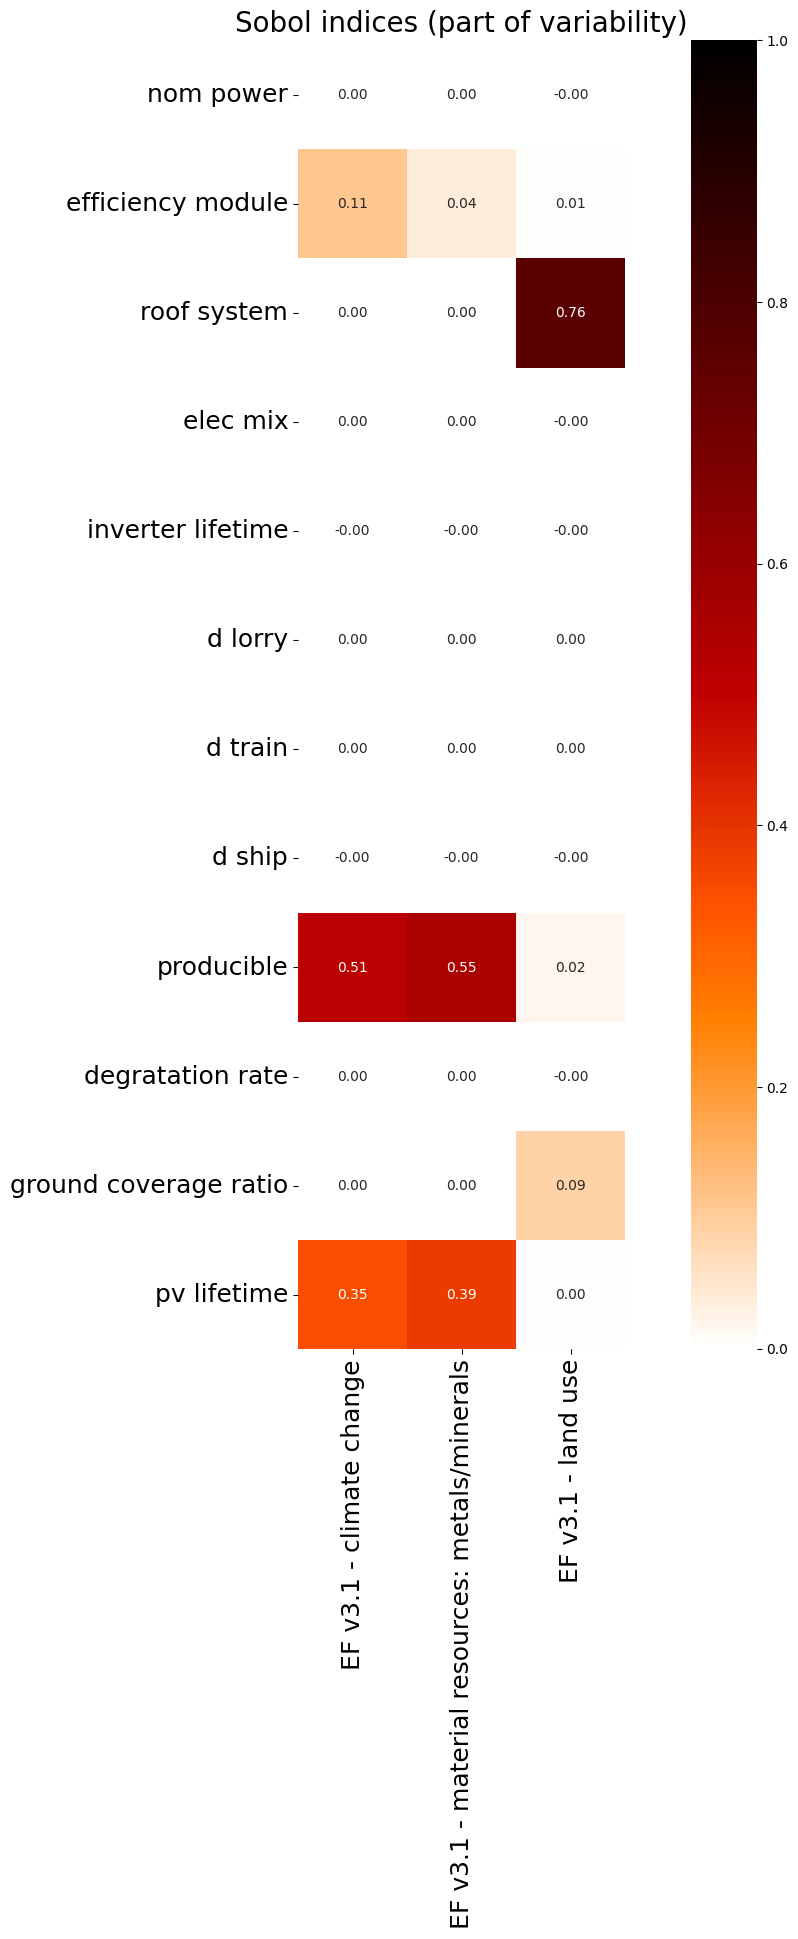

In [46]:
# This function also provides Monte Carlo samples, followed by the calculation of the Sobol indices and displays :
# - "Violin" plots, analogous to previous ones
# - A cumulative plot of Sobol indices
# - A "heatmap" similar to that of OAT analysis
# - Raw data
agb.incer_stochastic_dashboard(install, impacts, functional_unit = energy)

# TODO : 
# - Explore the data
# - Compare the output of the "heatmap" with OAT, by selecting "relative to mean"
# - How do you explain the difference with respect to OAT for the parameter "ground_coverage" ?
# - Come back to "raw indices" : 
#   which parameters should we select to explain at least 80% of the variance in the category of "land use" ?


# 🔧 Generation of simplified models

Sobol indices allowing the user to select automatically a subassembly of dominant parameters, 
explaining a predefined part (min-ratio) of the final variability.

Replacing other parameters by their median value, we obtain simplified algebraic models.

In [47]:
simplified = agb.sobol_simplify_model(
    install, # The model
    impacts, # Impacts to consider
    functional_unit = energy,
    n=2000, # For large model, you may test other value and ensure ST and sum(S1) are close to 1.0 
    fixed_mode = agb.FixedParamMode.MEDIAN, # We replace minor parameters by median by default,
    min_ratio=0.8, # Min ratio of variability to explain
    num_digits=3)

# TODO, explore other values of min_ratio, and their impact on the number of selected parameters

Generating samples ...
Transforming samples ...


/home/rjolivet/atelier-acv/.venv/lib/python3.10/site-packages/scipy/stats/_qmc.py:993: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


Processing sobol for ('ecoinvent-3.10.1', 'EF v3.1', 'climate change', 'global warming potential (GWP100)')


/home/rjolivet/atelier-acv/.venv/lib/python3.10/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


Processing sobol for ('ecoinvent-3.10.1', 'EF v3.1', 'material resources: metals/minerals', 'abiotic depletion potential (ADP): elements (ultimate reserves)')
Processing sobol for ('ecoinvent-3.10.1', 'EF v3.1', 'land use', 'soil quality index')
> Method :  EF v3.1 - climate change
S1:  0.976719063935852
S2:  0.07456672753109754
ST:  1.0121901012816692
Selected params :  ['producible', 'lifetime'] explains:  0.8581756210830179


-10.4/(Producible*(0.994**Lifetime - 1))

> Method :  EF v3.1 - material resources: metals/minerals
S1:  0.9817920576199514
S2:  0.047263029325327055
ST:  1.0101612022994366
Selected params :  ['producible', 'lifetime'] explains:  0.9358269769900589


-0.000546/(Producible*(0.994**Lifetime - 1))

> Method :  EF v3.1 - land use
S1:  0.8847782124256042
S2:  -0.001156291576982913
ST:  1.0985210679969966
Selected params :  ['rooftop', 'ground_coverage_ratio'] explains:  0.8495882531949013


(0.242*GroundCoverageRatio - 1.83*Rooftop + 1.83)/GroundCoverageRatio

In [48]:
# Display of the first simplified model (climate change)
simplified[0].expr

-10.4/(producible*(0.994**lifetime - 1))

In [49]:
# Display of the second simplified model  (resource depletion)
simplified[1].expr

-0.000546/(producible*(0.994**lifetime - 1))

In [50]:
# Display of the third simplified model  (land use)
simplified[2].expr

(-1.83*rooftop + 0.242*ground_coverage_ratio + 1.83)/ground_coverage_ratio

# 💡 Validation of simplified models

Simplified models can be compared to the reference model (complete), by using the function **compare_simplified**. This function conducts itself the same Monte Carlo generation of scenarios for both models and compare their results. R² is calculated : this quantifies the alignment of the simplified model to the referenc model, ranging between 0 and 1 (1 being a perfectly aligned simplified model).

Generating samples ...
Transforming samples ...


/home/rjolivet/atelier-acv/.venv/lib/python3.10/site-packages/lca_algebraic/stats.py:1363: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "R² : %0.3g" % r_value,


Generating samples ...
Transforming samples ...


/home/rjolivet/atelier-acv/.venv/lib/python3.10/site-packages/lca_algebraic/stats.py:1363: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "R² : %0.3g" % r_value,


Generating samples ...
Transforming samples ...


/home/rjolivet/atelier-acv/.venv/lib/python3.10/site-packages/lca_algebraic/stats.py:1363: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "R² : %0.3g" % r_value,


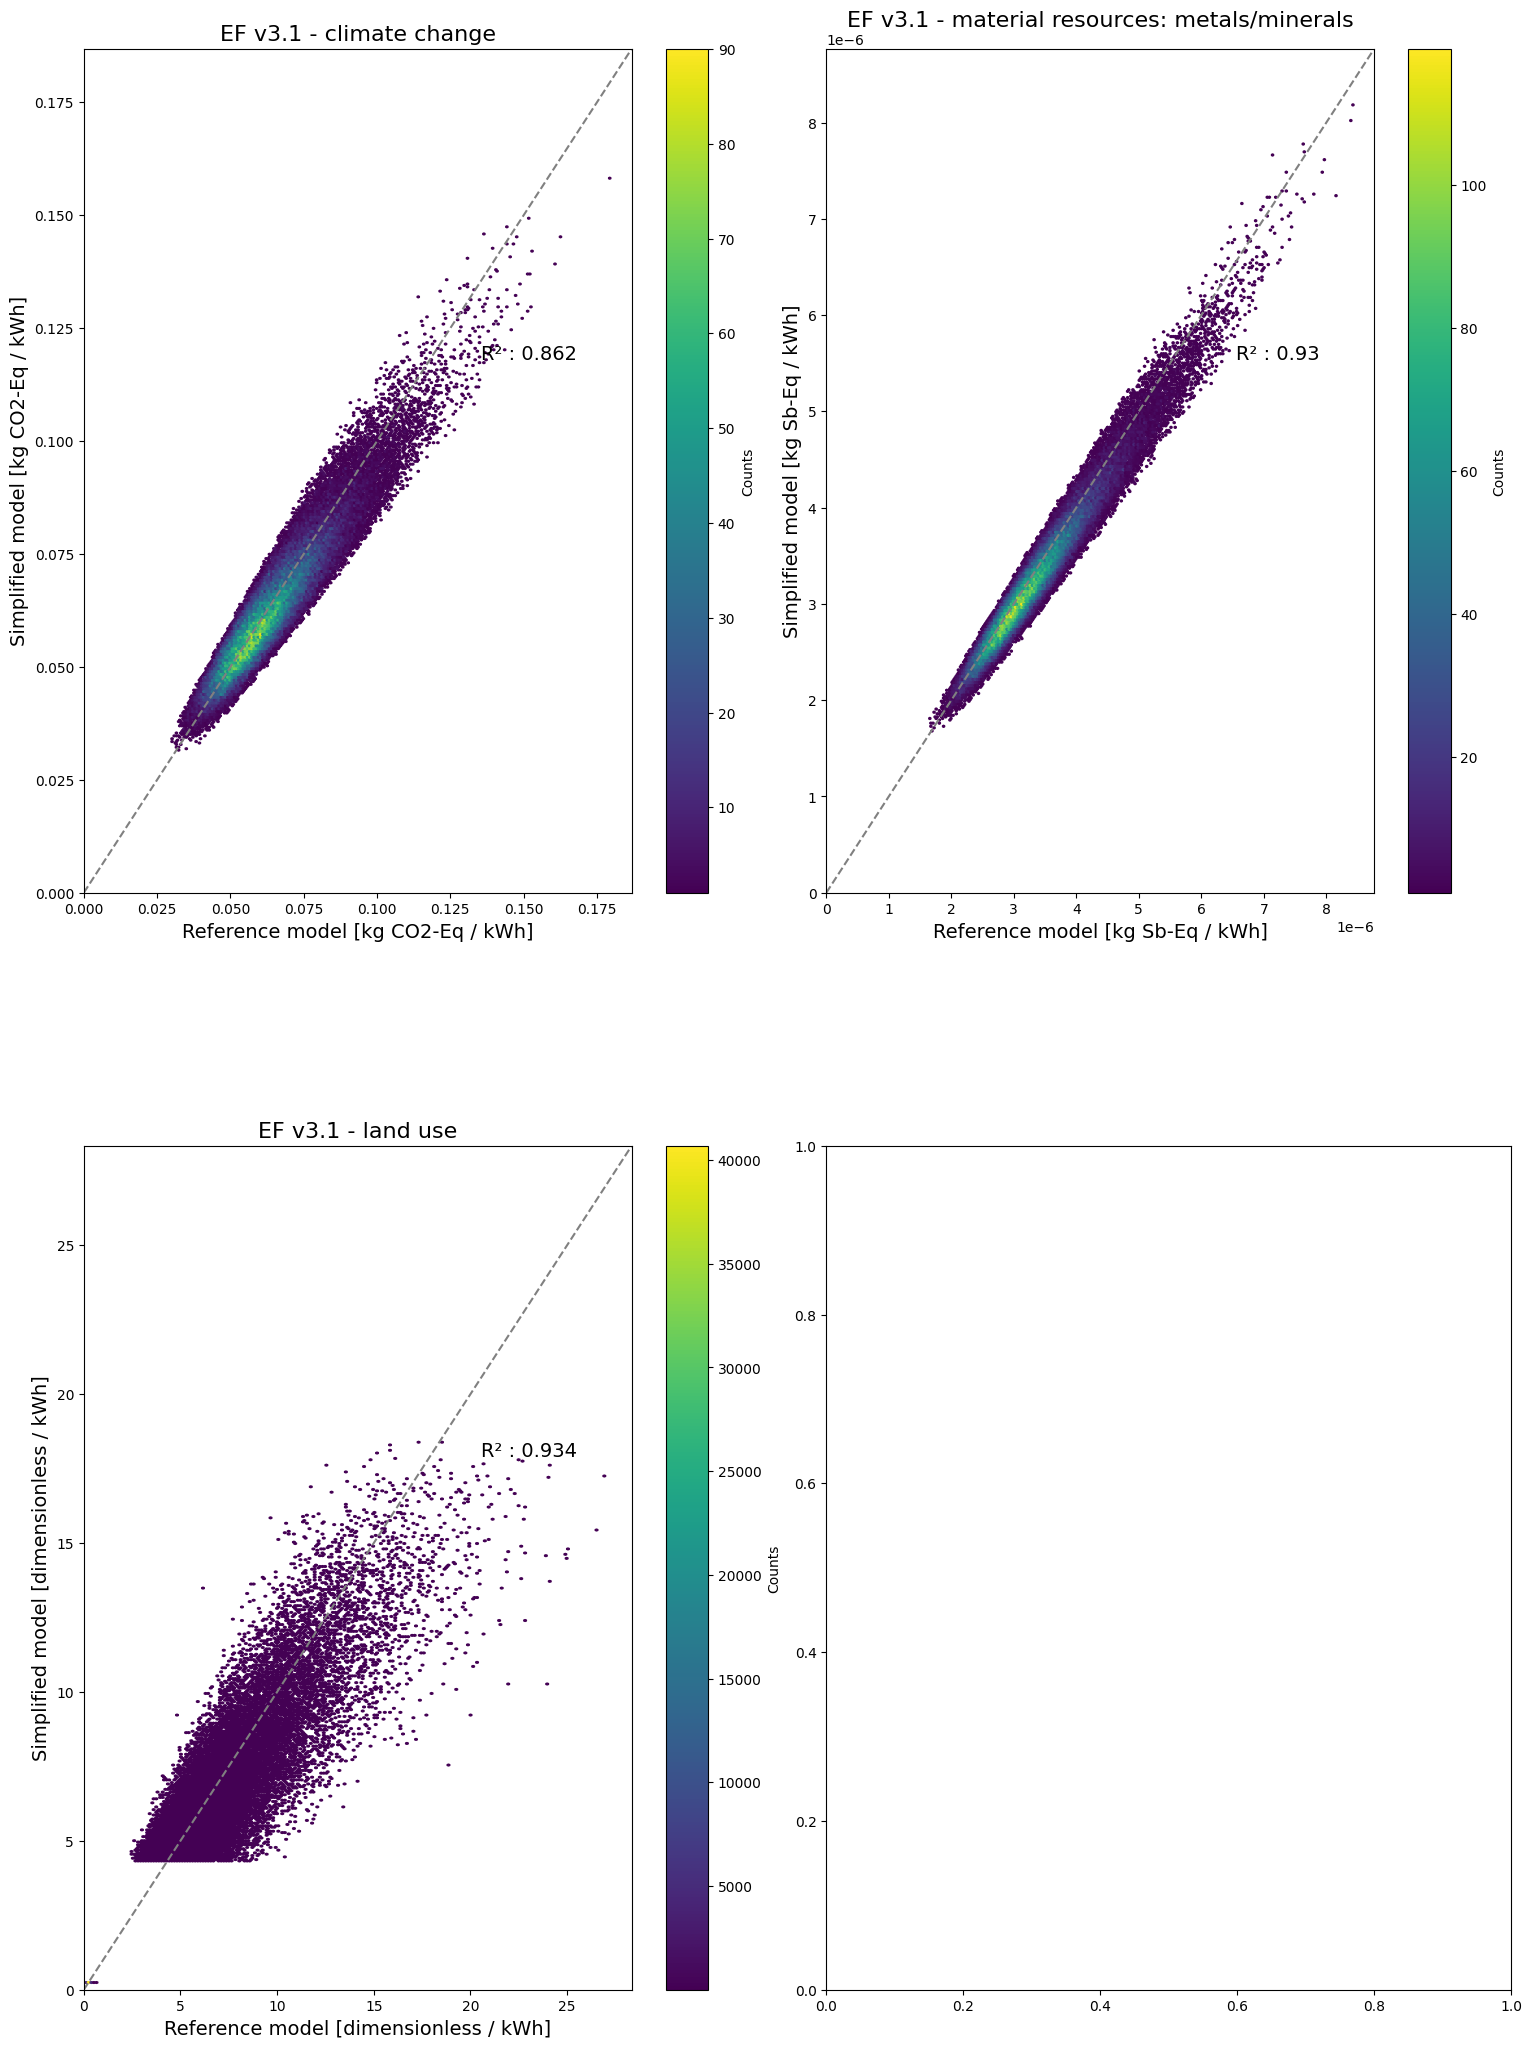

In [51]:
agb.compare_simplified(
    model=install,
    methods=impacts,
    simpl_lambdas=simplified,
    functional_unit = energy,
    func_unit_name="kWh",
    residuals=True)

# TODO compare the level of alignement of simplified models and R²

 # Homogeneity of physical units

The lastest version of *lca_algebraic* integrates with the librairy [Pint](pint.readthedocs.io/en/stable/).

It enables, as an option, to automatically check the physical homogeneity of formulas / units.

Full [documentation here](https://lca-algebraic.readthedocs.io/en/stable/api/units.html)

## Activate the Unit checks

In [52]:
from lca_algebraic import Settings
from lca_algebraic import unit_registry as u # Short alias to units

Settings.units_enabled = True

## Usage

Once units are activated, `newFlotParam(...)` creates a [Pint Quantity](https://pint.readthedocs.io/en/stable/user/defining-quantities.html), which holds two fields :
 - `.units` : The physical unit (the one defined in the unit argument of newFloatParam)
 - `.magnitude`:  The amount / magnitude : A static float value or Sympy expression (the parameter itself)

You need to specify the unit for any static value used in formulas.

You can specify them using either of the following syntaxes :
```
<value> * <unit> or
<value> | <unit>
```

In [53]:
mass_param = agb.newFloatParam("p1", unit="kg", default=10)
print("whole param:", mass_param)
print("its unit:", mass_param.units)
print("its magnitude:", mass_param.magnitude)

whole param: p1 kilogram
its unit: kilogram
its magnitude: p1


In [54]:
# Defining constant values
MASS_PER_SURFACE = 10 | u.kg / u.meter ** 2
print(MASS_PER_SURFACE)

10 kilogram / meter ** 2


In [55]:
# Convert to other units

# Notice that for a Sympa parameter, the magnitude is still a Sympy formula
print("param in gram : ", mass_param.to(u.gram))

param in gram :  1000.0*p1 gram


In [56]:
# You can also use the syntax '|'
print("MASS_PER_SURFACE ==> kg/cm2 : ", MASS_PER_SURFACE | u.kg / u.centimeter ** 2)

MASS_PER_SURFACE ==> kg/cm2 :  0.001 kilogram / centimeter ** 2


## Sums and auto scale

You can add quantities of incompatible units. **Pint** raises an exception if you try to.

By default, **auto scale** is disabled even compatible units (kilogram and gram for instance) cannot be added if they are not explicitely converted.

Autoscale can be enabled, to automatically transform units :
```
u.autoscale = True
```

Yet, we **recommend to leave it disabled**, in order to have the developper fully aware of the required unit conversions

In [57]:
# You can't add apples with bananas
mass = 10 | u.kilogram
distance = 20 | u.meter

mass + distance

DimensionalityError: Cannot convert from 'kilogram' ([mass]) to 'meter' ([length])

In [58]:
# By default, auto scale of quantities with compatible units is disabled

mass_kg = 1 | u.kg
mass_gram = 2 | u.gram

# This will fail
mass_kg + mass_gram

Exception: Auto scale disabled : explicit convertio of '2 gram' to kilogram required

In [59]:
# This works
mass_kg.to(u.gram) + mass_gram


<Quantity(1002.0, 'gram')>

## Units in the inventory

When assigning a quantity an exchange, either via `newActivity()` or `updateActivity()`, *lca_algebraic* will check that the unit of the amount is either :
* The unit of the **target activity** of the exchange
* The unit of the **target activity** of the exchange, divided by the **unit of the output**.

For instance, if you define an activity **act1**, creating 1 kg of a product, and using some electricity (in kWh), then the exchange for electricity should be defined either in *kWh* (implicitely “for one 1 kg of product created”) or in *kWh/kg*.

In [68]:
# The unit of electricity is kilowatthour
print(elec_cn)

# Both would work
act1 = agb.newActivity(
    db_name=USER_DB,
    name="act1",
    unit="kg", # Unit of theis activity
    exchanges={
        elec_cn: 100 | u.kWh, # Ok
        elec_cn: 100 | u.kWh / u.kg, # Ok
    })

[WARNING] Activity 'act1' was already in 'foreground'. Overwriting it


'market for electricity, medium voltage' (kilowatt hour, CN-CSG, None)


In [69]:
# Both would work
act1 = agb.newActivity(
    db_name=USER_DB,
    name="act1",
    unit="kg", # Unit of theis activity
    exchanges={
        elec_cn: 100 | u.kilowatt # Would fail
    })

[WARNING] Activity 'act1' was already in 'foreground'. Overwriting it


DimensionalityError: Cannot convert from 'kilowatt' (Unit of amount '100 kilowatt' is not compatible with physical unit of exchange 'hour * kilowatt' or the unit of exchange divided by the unit of the activity : 'hour * kilowatt / kilogram') to 'hour * kilowatt' ()

### 🔧 Create an inventory with converted units

Let's create an activity of a gaz turbine producing electricity.

In ecoinvent, the gas is expressed in cubic meter, not in energy.

Let's introduce : 
- An efficiency parameter, in percentage
- A static parameter of energetic density of methane (37 megajoule per cubic meter)



In [81]:
methane = agb.findTechAct("market for natural gas, high pressure", loc="RoW")

In [101]:
turbine_efficiency = agb.newFloatParam(
    "turbine_efficiency", 
    default=0.4, min=0.2, max=0.8,
    unit="ratio")

[WARNING] [ParamRegistry] Param turbine_efficiency was already defined in '<project>' : overriding.


In [109]:
METHANE_ENERGETIC_INTENSITY = 35 | (u.megajoule  / (u.meter ** 3))

elec_turbine = act1 = agb.newActivity(
          db_name=USER_DB,
          name="elec_turbine",
          unit="kilowatthour",
          exchanges={
             methane: 1 / (METHANE_ENERGETIC_INTENSITY * turbine_efficiency) | (u.meter ** 3 / u.kilowatthour)
          })

[WARNING] Activity 'elec_turbine' was already in 'foreground'. Overwriting it


In [110]:
agb.printAct(elec_turbine)

elec_turbine (1.000000 kilowatthour)  \
                                                                            input   
market for natural gas, high pressure  market for natural gas, high pressure[RoW]   

                                                                             \
                                                                     amount   
market for natural gas, high pressure  0.102857142857143/turbine_efficiency   

                                                    
                                              unit  
market for natural gas, high pressure  cubic meter

In [98]:
METHANE_ENERGETIC_INTENSITY

<Quantity(35, 'megajoule / meter ** 3')>